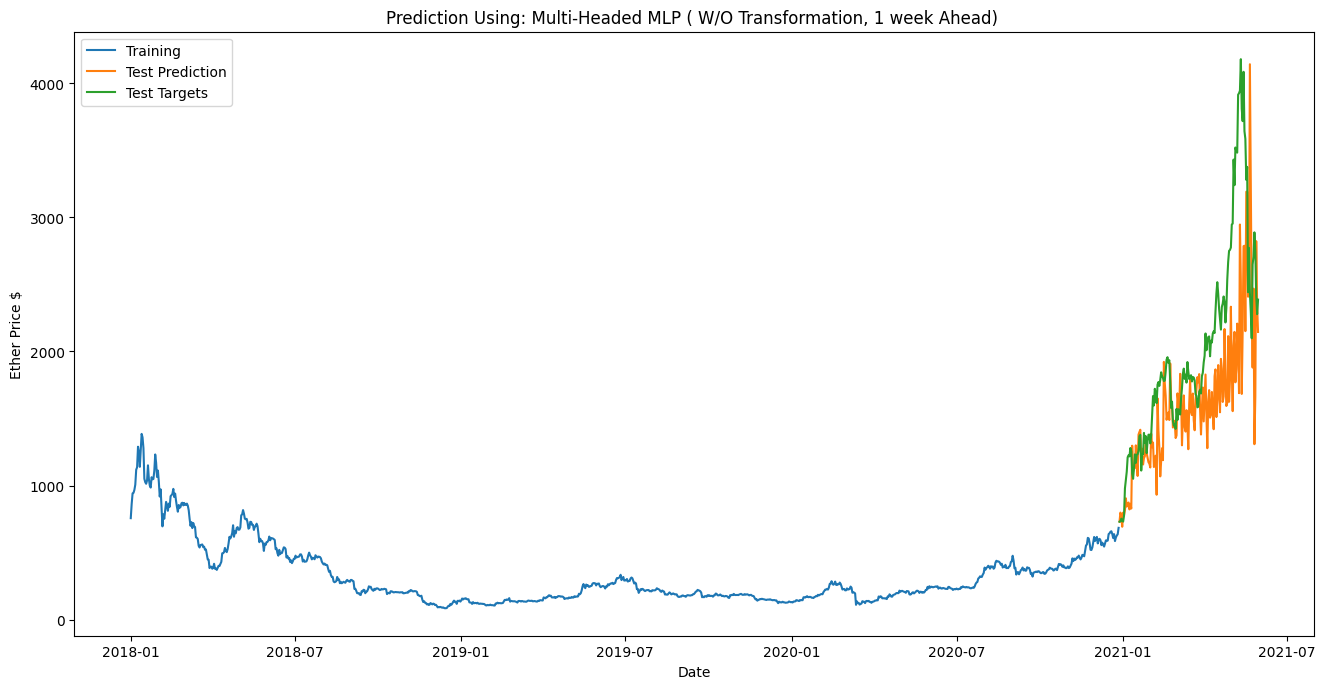

Total RMSE is:  651.4454857882769
Total APE is:  19.590037566086618
Runtime of the program is 433.73930263519287


In [398]:
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import time
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from numpy import split
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# split a multivariate sequence into samples for providing test samples
def split_sequences_test(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(int(len(sequences)/n_steps_out)):
        # find the end of this pattern
        end_ix = i*n_steps_out + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i*n_steps_out:end_ix, :], sequences[end_ix:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
    
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = metrics.mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = np.sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores


df=pd.read_csv('D:\\Ethereum project\\Data Processing\\5-original2016-43.csv', header=0, parse_dates=['Date'], index_col=['Date'])

# starting time
start = time.time()

#start analysis data from 1/1/2018
df=df.loc['2018-01-01':,:]

# Perform Log Transformation
#df=np.log(df+1)

# Perform square root Transformation
#df=np.sqrt(df)

n_input = 14
n_out = 7

scaler=MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_norm.index=df.index

# restructure into windows of weekly data
train, test = df_norm.loc['2018-01-01':'2020-12-27'],  df_norm.loc['2020-12-14':'2021-05-30']

train = array(split(train, len(train)/n_out))
test = array(split(test, len(test)/n_out))

train_index = df_norm.loc['2018-01-01':'2020-12-27'].index
test_index = df_norm.loc['2020-12-28':'2021-05-30'].index
y_train = train[:,:,0].reshape(train.shape[0]*train.shape[1]) 

# convert history into inputs and outputs
# flatten data
sequences_train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
train_x, train_y= split_sequences(sequences_train, n_input, n_out)

sequences_test = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
test_x, test_y= split_sequences_test(sequences_test, n_input, n_out)

train_x, validation_x, train_y, validation_y = train_test_split(train_x, train_y, test_size=0.3, random_state=2)

n_features = train_x.shape[2]

#--------------------------
# Multi-headed MLP
#--------------------------
ModelType='Multi-headed MLP'
# separate input data
train_x = [train_x[:, :, i] for i in range(n_features)]
validation_x = [validation_x[:, :, i] for i in range(n_features)]


# first input model
visible= [Input(shape=(n_input,)) for i in range(n_features)]
dense=[Dense(40, activation='relu')(visible[i]) for i in range(n_features)]

# merge input models
merge = concatenate([dense[i] for i in range(n_features)])
output = Dense(n_out)(merge)
model_mlp = Model(inputs=[visible[i] for i in range(n_features)], outputs=output)
model_mlp.compile(optimizer='Adam', loss='mse', metrics='mape')

# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

# fit
history = model_mlp.fit(train_x, train_y, validation_data=(validation_x, validation_y), epochs=1000, callbacks=[es], verbose=0)


# evaluate predictions days for each week
X = [test_x[:, :, i] for i in range(43)]
predictions = model_mlp.predict(X, verbose=0)
predictions = predictions.reshape(predictions.shape[0]*predictions.shape[1])
        

# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])
y_predrev=(scaler.inverse_transform(np.concatenate((predictions.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W/O Transformation, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)
# total time taken
print(f"Runtime of the program is {end - start}")

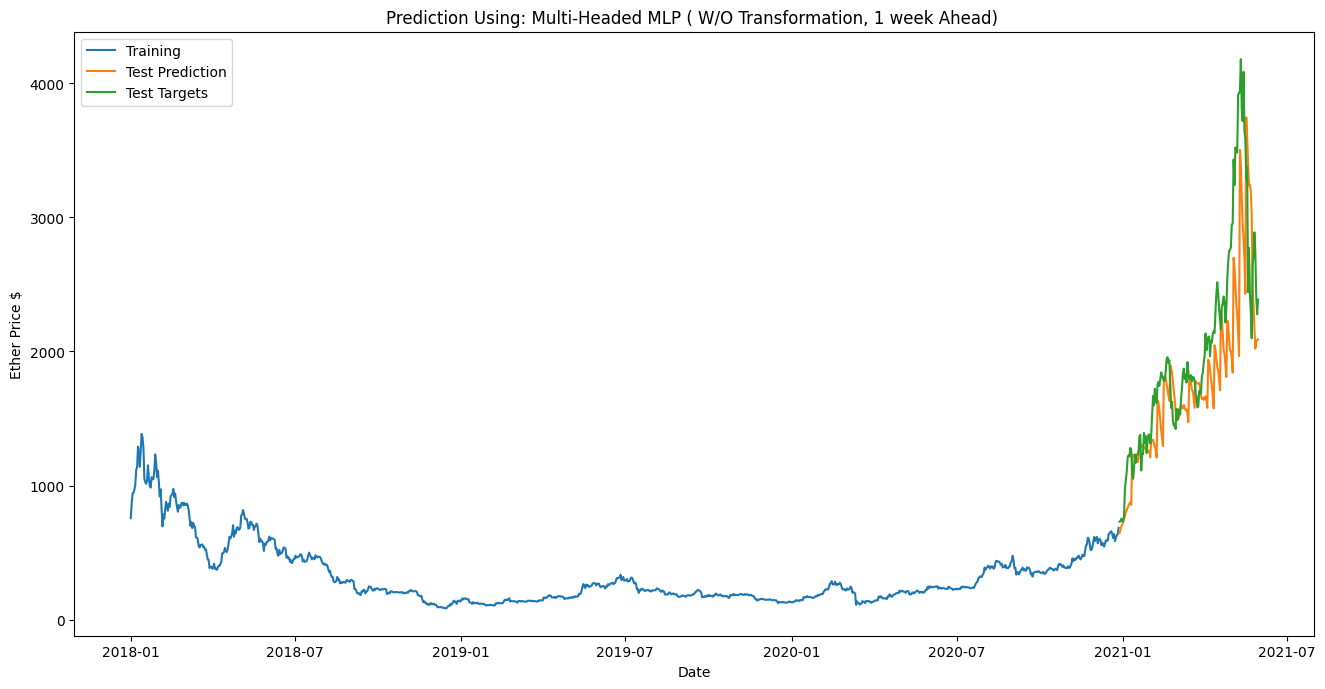

Total RMSE is:  651.4454857882769
Total APE is:  19.590037566086618


In [399]:
# Rolling Mean
history = list(y_train)
predict=[]
for i in list(range(len(test_x))):
    X = [test_x[i, :, f].reshape(1,-1) for f in range(43)]
    modpred = model_mlp.predict(X, verbose=0)
    sudo = history + list(modpred[0])
    rolling = pd.Series(sudo).rolling(window=7)
    rolling_mean = rolling.mean()
    filtpred = list(rolling_mean[-7:].values)
    predict = predict + filtpred
    history = history + list(test_y[i])
    
predict_rollmean = array(predict)    
# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])
y_predrev_rollmean=(scaler.inverse_transform(np.concatenate((predict_rollmean.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev_rollmean, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W/O Transformation, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)

In [393]:
array(train_x).shape

(43, 750, 14)

In [394]:
array(train_y).shape

(750, 7)

In [396]:
len(y_predrev)

154

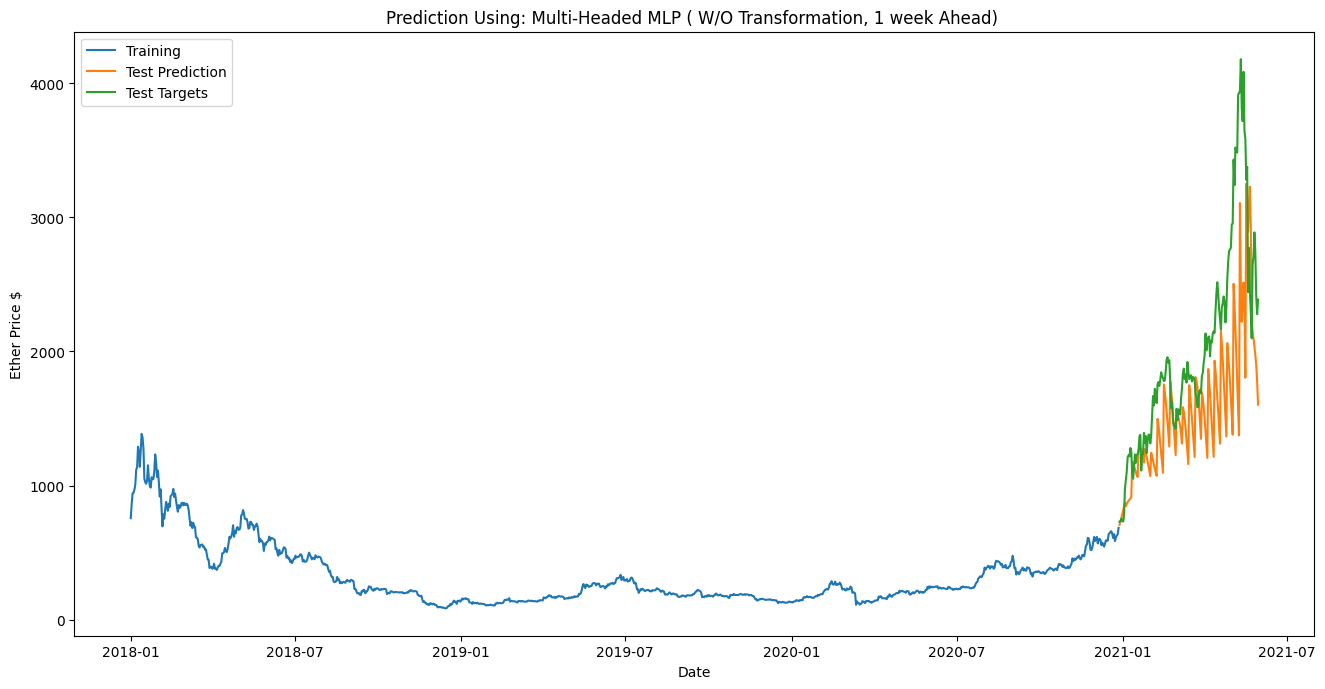

Total RMSE is:  666.3053313587703
Total APE is:  20.684779469380683


In [401]:
# Fourier Transform
#https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    Denoises data using the fast fourier transform.
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)      
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """

    n = len(x)
    # compute the fft
    fft = np.fft.fft(x, n)
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    if to_real:
        clean_data = clean_data.real
    return clean_data


history = list(y_train)
predict=[]
n_components=0.0009
for i in list(range(len(test_x))):
    X = [test_x[i, :, f].reshape(1,-1) for f in range(43)]
    modpred = model_mlp.predict(X, verbose=0)
    sudo = history + list(modpred[0])
    FT=fft_denoiser(sudo, n_components, to_real=True)
    filtpred = FT[-7:]
    predict = predict + list(filtpred)
    history = history + list(test_y[i])
    
predict = array(predict)    
# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])
y_predrev=(scaler.inverse_transform(np.concatenate((predict.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W/O Transformation, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

# end time
end = time.time()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)



c:\users\98912\.virtualenvs\98912-eapzcx7p\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


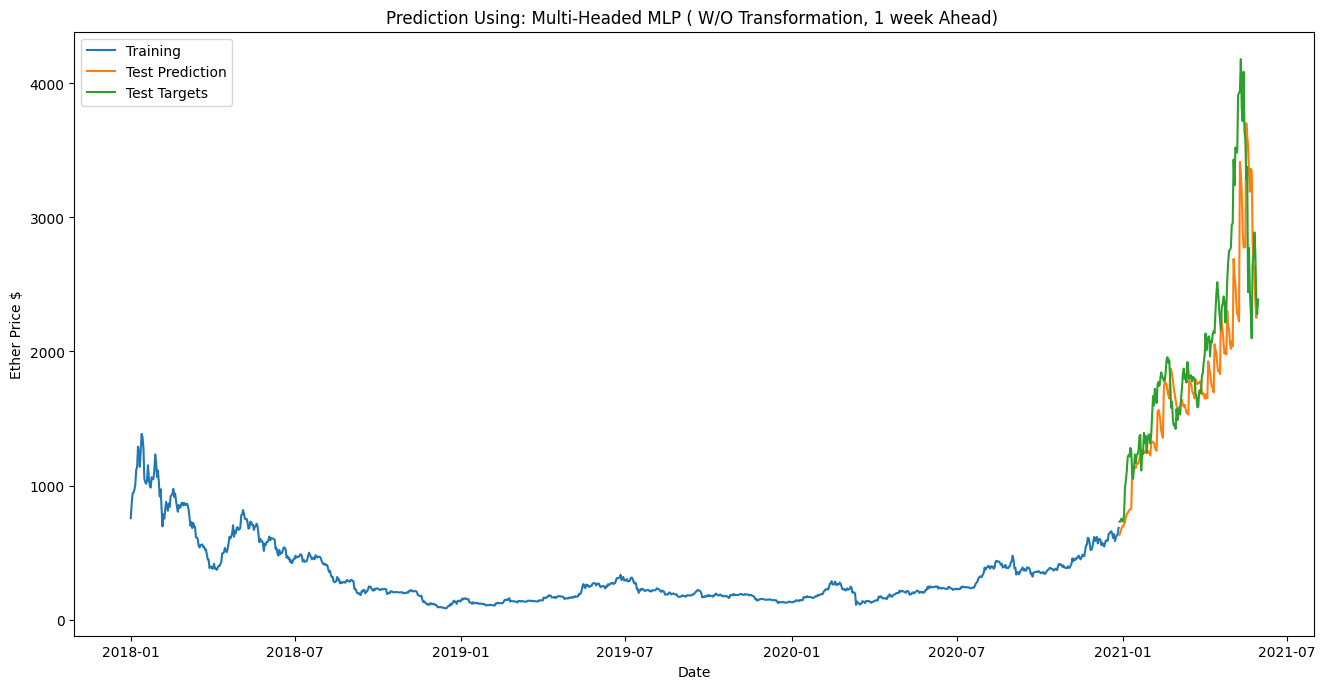

Total RMSE is:  666.3053313587703
Total APE is:  20.684779469380683


In [402]:
# Simple Exponential Smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

history = list(y_train)
predict=[]
n_components=0.0009
for i in list(range(len(test_x))):
    X = [test_x[i, :, f].reshape(1,-1) for f in range(43)]
    modpred = model_mlp.predict(X, verbose=0)
    sudo = history + list(modpred[0])
    model = SimpleExpSmoothing(np.asarray(sudo))
    fit = model.fit(smoothing_level=.18)
    fitvalue = fit.fittedvalues
    filtpred = fitvalue[-7:]
    predict = predict + list(filtpred)
    history = history + list(test_y[i])
    
predict_simex = array(predict)    
# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])
y_predrev_simex=(scaler.inverse_transform(np.concatenate((predict_simex.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev_simex, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W/O Transformation, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)

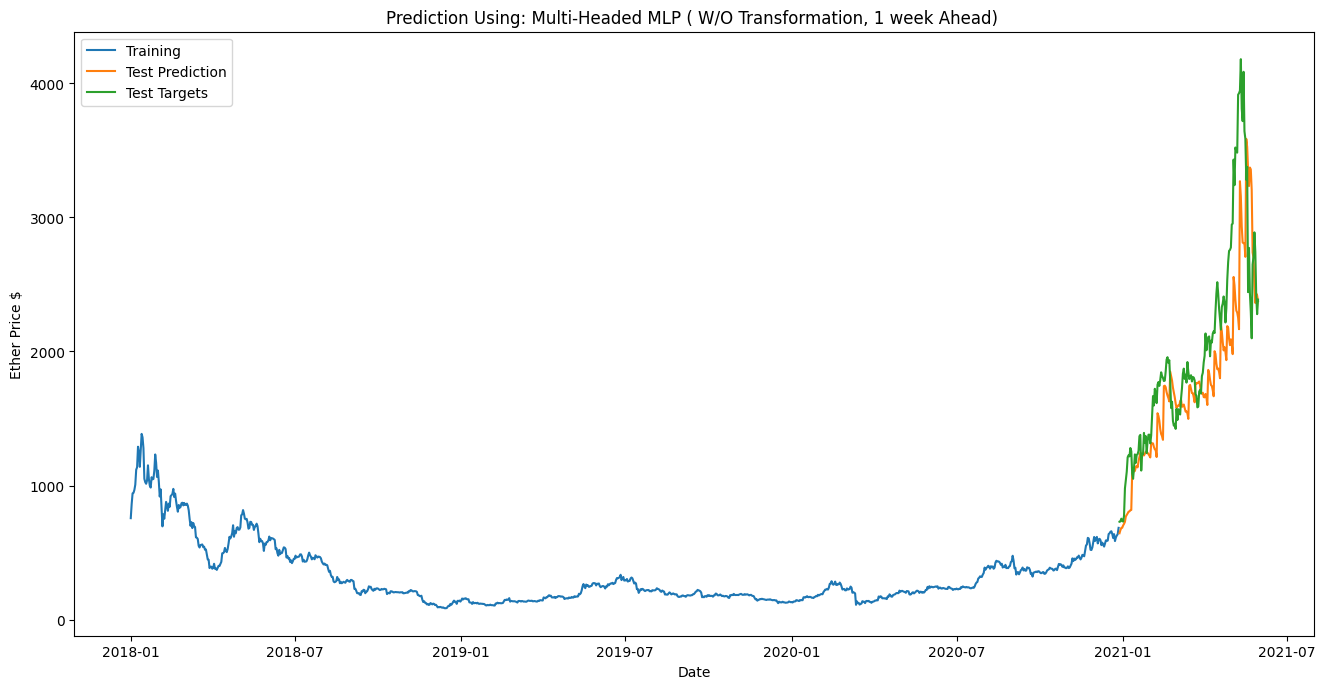

Total RMSE is:  666.3053313587703
Total APE is:  20.684779469380683


In [403]:
# Kalman Filter
# https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d

from kalmanfilter import KalmanFilter

# -----------------------------------------------------------------------------
def Kfilter(sequence):
    if __name__ == "__main__":
        # -------------------------------------------------------------------------
        # generate noisy observations
        Z = sequence

        # kalman settings
        A = np.expand_dims(np.ones((len(Z),1)), axis=1) # transition matrix
        xk = np.array([[1]]) # initial mean estimate

        B = np.expand_dims(np.zeros((len(Z),1)), axis=1) # control-input matrix
        U = np.zeros((len(Z), 1)) # control-input vector

        Pk = np.array([[1]]) # initial covariance estimate
        Q = np.ones((len(Z))) * 0.0003 # process noise covariance

        H = A.copy() # observation matrix
        R = np.ones((len(Z))) * 0.011 # measurement noise covariance

        # -------------------------------------------------------------------------
        # run Kalman filter
        kf = KalmanFilter(A=A, xk=xk, B=B, Pk=Pk, H=H, Q=Q, R=R)
        states, errors = kf.filter(Z=Z, U=U)
        kalman_gain = np.stack([val.item() for val in kf.kalman_gains])
        # as a flat array
        states = np.stack([val.item() for val in states])
    return states

    
history = list(y_train)
predict=[]
for i in list(range(len(test_x))):
    X = [test_x[i, :, f].reshape(1,-1) for f in range(43)]
    modpred = model_mlp.predict(X, verbose=0)
    sudo = history + list(modpred[0])
    states = Kfilter(sudo)
    filtpred = states[-7:]
    predict = predict + list(filtpred)
    history = history + list(test_y[i])
    
predict_kf = array(predict)    
# Plot rescaled outputs
y_trainrev=(scaler.inverse_transform(train.reshape(train.shape[0]*train.shape[1],train.shape[2] ))[:,0])
y_testrev=(scaler.inverse_transform(np.concatenate((test_y.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])
y_predrev_kf=(scaler.inverse_transform(np.concatenate((predict_kf.reshape(-1, 1), np.zeros((154,42))), axis=1))[:,0])

plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev_kf, label='Test Prediction')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W/O Transformation, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()

rmse = np.sqrt(np.mean((y_testrev-y_predrev)**2))
ape = np.mean(np.abs((y_testrev-y_predrev)*100/y_testrev))
print('Total RMSE is: ' , rmse)
print('Total APE is: ' , ape)

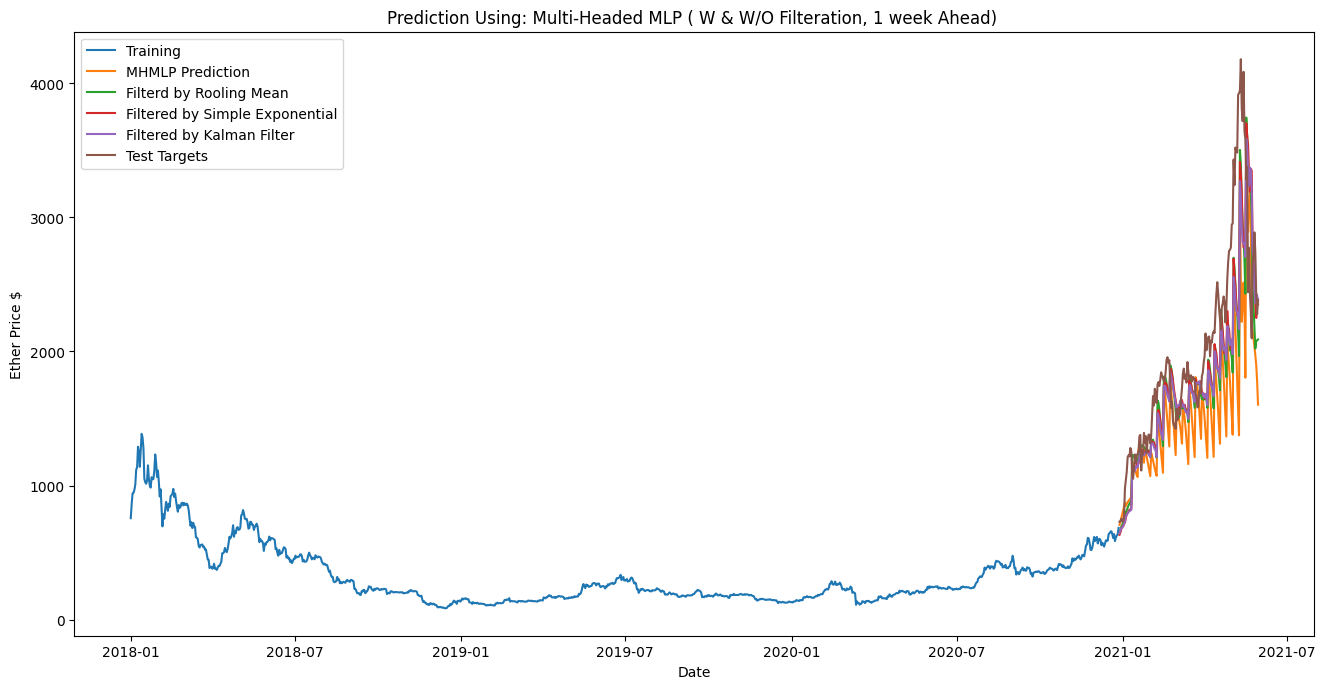

In [404]:
plt.figure(figsize=(16,8), dpi=100)
plt.plot(train_index, y_trainrev, label='Training')
plt.plot(test_index, y_predrev, label='MHMLP Prediction')
plt.plot(test_index, y_predrev_rollmean, label='Filterd by Rooling Mean')
plt.plot(test_index, y_predrev_simex, label='Filtered by Simple Exponential')
plt.plot(test_index, y_predrev_kf, label='Filtered by Kalman Filter')
plt.plot(test_index, y_testrev, label='Test Targets')
plt.gca().set(title='Prediction Using: Multi-Headed MLP ( W & W/O Filteration, 1 week Ahead) ', xlabel='Date', ylabel='Ether Price $')
plt.legend()
plt.show()